In [1]:
from darts.models import StatsForecastAutoETS, StatsForecastAutoARIMA, StatsForecastAutoTheta
from utility import ForecastingManager

Support for Torch based models not available. To enable them, install "darts", "u8darts[torch]" or "u8darts[all]" (with pip); or "u8darts-torch" or "u8darts-all" (with conda).
/home/mahdi/anaconda3/envs/darts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notes
This code should be able to automatically fit different models on different datasets. 

The main data structure will be a list of dictionaries, where each element of the list corresponds to a model-dataset pair and has the following format.

{<br>
    dataset_name:str,<br>
    model_name:str,<br>
    train_data:TimeSeries,<br>
    test_data:TimeSeries,<br>
    test_data_pred:TimeSeries,<br>
    summary_errors:{'MAPE':float}<br>
}

In [2]:
# Example usage
forecasting_manager = ForecastingManager()
forecasting_manager.add_model_data_pair('datasets/retail/air_passengers.csv', \
                                    StatsForecastAutoETS(season_length=12, model="AZZ"))

forecasting_manager.add_model_data_pair('datasets/retail/air_passengers.csv', \
                                    StatsForecastAutoARIMA(season_length=12))

forecasting_manager.add_model_data_pair('datasets/retail/air_passengers.csv', \
                                    StatsForecastAutoTheta(season_length=12))


# Get and print the results
entries_and_results = forecasting_manager.get_entries_and_results()
print(entries_and_results[0].keys())

dict_keys(['dataset_address', 'model_name', 'train_series', 'test_series', 'test_series_pred', 'eval_metric_funcs', 'summary_errors'])


In [3]:
for curr_entry_and_results in entries_and_results:
    print(f"Now fitting, {curr_entry_and_results['model_name']} on {curr_entry_and_results['dataset_address']}.")
    curr_entry_and_results['model_name'].fit(curr_entry_and_results['train_series'])
    num_test = len(curr_entry_and_results['test_series'])
    curr_entry_and_results['test_series_pred'] = curr_entry_and_results['model_name'].predict(num_test)

    print(f"adding errors")
    for a_func in curr_entry_and_results['eval_metric_funcs']:
        

        curr_entry_and_results['summary_errors'][a_func.__name__] = \
            a_func(curr_entry_and_results['test_series'], curr_entry_and_results['test_series_pred'])

Now fitting, StatsForecastAutoETS(season_length=12, model=AZZ) on datasets/retail/air_passengers.csv.
adding errors
Now fitting, StatsForecastAutoARIMA(season_length=12) on datasets/retail/air_passengers.csv.
adding errors
Now fitting, StatsForecastAutoTheta(season_length=12) on datasets/retail/air_passengers.csv.
adding errors


In [9]:
for curr_entry_and_results in entries_and_results:
    print([curr_entry_and_results[key] for key in ['model_name', 'summary_errors']])

[StatsForecastAutoETS(add_encoders=None, season_length=12, model=AZZ), {'mape': 6.896987277178006}]
[StatsForecastAutoARIMA(add_encoders=None, season_length=12), {'mape': 4.148572030704047}]
[StatsForecastAutoTheta(season_length=12), {'mape': 5.41321166979053}]


<Axes: xlabel='ds'>

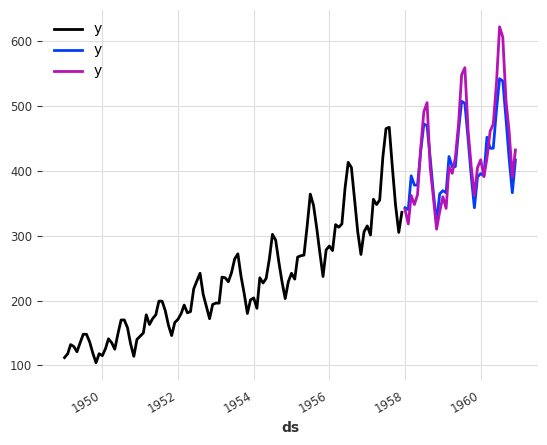

In [5]:
curr_entry_and_results['train_series'].plot()
curr_entry_and_results['test_series_pred'].plot()
curr_entry_and_results['test_series'].plot()

In [7]:
entries_and_results

[{'dataset_address': 'datasets/retail/air_passengers.csv',
  'model_name': StatsForecastAutoETS(add_encoders=None, season_length=12, model=AZZ),
  'train_series': <TimeSeries (DataArray) (ds: 108, component: 1, sample: 1)>
  array([[[112.]],
  
         [[118.]],
  
         [[132.]],
  
         [[129.]],
  
         [[121.]],
  
         [[135.]],
  
         [[148.]],
  
         [[148.]],
  
         [[136.]],
  
         [[119.]],
  
  ...
  
         [[356.]],
  
         [[348.]],
  
         [[355.]],
  
         [[422.]],
  
         [[465.]],
  
         [[467.]],
  
         [[404.]],
  
         [[347.]],
  
         [[305.]],
  
         [[336.]]])
  Coordinates:
    * ds         (ds) datetime64[ns] 1949-01-01 1949-02-01 ... 1957-12-01
    * component  (component) object 'y'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'test_series': <TimeSeries (DataArray) (ds: 36, component: 1, sample: 1)>
  array